In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import cvxopt as opt
import matplotlib.pyplot as plt
from cvxopt import blas, solvers
from datetime import datetime

In [2]:
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 10000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df

In [3]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [4]:
symbols = ['FANG', 'TSLA', 'WFC', 'BIDU', 'CRM', 'SQ', 'AAPL']
start_date = datetime(2018,7,1) # Year, Month, Day
end_date = datetime(2021,7,1) # Year, Month, Day

stock_data = web.get_data_yahoo(symbols, start_date, end_date)

stock_data = stock_data['Adj Close']
stock_data.tail()

Symbols,FANG,TSLA,WFC,BIDU,CRM,SQ,AAPL
Date,,,,,,,
2021-06-25,95.341446,671.869995,46.001392,202.639999,241.869995,239.940002,132.717178
2021-06-28,91.540062,688.719971,45.416206,205.179993,244.570007,246.600006,134.382233
2021-06-29,91.688560,680.760010,44.424370,207.669998,245.809998,248.869995,135.927658
2021-06-30,92.945786,679.700012,44.920288,203.899994,244.270004,243.800003,136.555817
2021-07-01,98.598358,677.919983,45.039310,201.460007,244.979996,241.850006,136.864899


In [5]:
stock_data

Symbols,FANG,TSLA,WFC,BIDU,CRM,SQ,AAPL
Date,,,,,,,
2018-07-02,121.074051,67.014000,50.571312,246.250000,140.429993,63.139999,45.111359
2018-07-03,121.776344,62.172001,49.888889,246.429993,137.839996,61.750000,44.325691
2018-07-05,123.602272,61.832001,49.601547,244.070007,139.770004,64.150002,44.682373
2018-07-06,126.383331,61.779999,50.185204,251.770004,141.399994,66.440002,45.301758
2018-07-09,127.975197,63.702000,50.975380,261.970001,141.759995,66.480003,45.930782
...,...,...,...,...,...,...,...
2021-06-25,95.341446,671.869995,46.001392,202.639999,241.869995,239.940002,132.717178
2021-06-28,91.540062,688.719971,45.416206,205.179993,244.570007,246.600006,134.382233
2021-06-29,91.688560,680.760010,44.424370,207.669998,245.809998,248.869995,135.927658


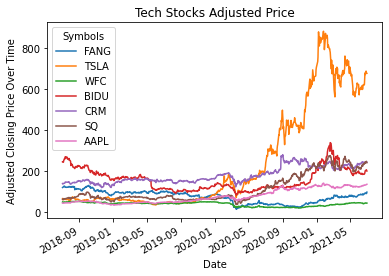

In [6]:
#stock_data_adjclosing_prices = stock_data
#plt.plot(len(stock_data_adjclosing_prices),stock_data_adjclosing_prices)
stock_data.plot() 
# plt.figure(figsize=(10,15))
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price Over Time')
plt.title('Tech Stocks Adjusted Price')

plt.show()

In [7]:
daily_log_returns = stock_data.pct_change()
daily_log_returns

Symbols,FANG,TSLA,WFC,BIDU,CRM,SQ,AAPL
Date,,,,,,,
2018-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,0.005801,-0.072254,-0.013494,0.000731,-0.018443,-0.022015,-0.017416
2018-07-05,0.014994,-0.005469,-0.005760,-0.009577,0.014002,0.038866,0.008047
2018-07-06,0.022500,-0.000841,0.011767,0.031548,0.011662,0.035698,0.013862
2018-07-09,0.012596,0.031110,0.015745,0.040513,0.002546,0.000602,0.013885
...,...,...,...,...,...,...,...
2021-06-25,0.021857,-0.011694,0.026560,0.040407,-0.007794,-0.017243,-0.002249
2021-06-28,-0.039871,0.025079,-0.012721,0.012535,0.011163,0.027757,0.012546
2021-06-29,0.001622,-0.011558,-0.021839,0.012136,0.005070,0.009205,0.011500


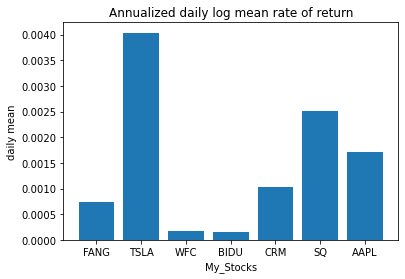

In [8]:
#calculate annualized daily mean
daily_log_mean = daily_log_returns.mean()

# grab each daily mean value for the y axis
height = []
for key in daily_log_mean.keys():
    height.append(daily_log_mean[key])
    
x_pos = np.arange(len(daily_log_mean.keys()))

# plot bars
plt.bar(x_pos, height)
 
# create names on the x-axis
plt.xticks(x_pos, daily_log_mean.keys())

# label chart
plt.xlabel("My_Stocks")
plt.ylabel("daily mean")
plt.title("Annualized daily log mean rate of return")

# show graphic
plt.show()

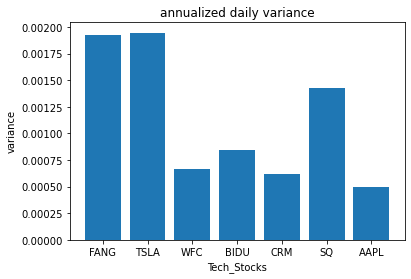

In [9]:
# calculate variance
daily_var = daily_log_returns.var() 

# grab each daily mean value for the y axis
height = []
for key in daily_var.keys():
    height.append(daily_var[key])


# arrange keys on x axis based on length
x_pos = np.arange(len(daily_var.keys()))


# plot bars
plt.bar(x_pos, height)
 
# create names on the x-axis
plt.xticks(x_pos, daily_var.keys())

# label chart
plt.xlabel("Tech_Stocks")
plt.ylabel("variance")
plt.title("annualized daily variance")

# show graphic
plt.show()

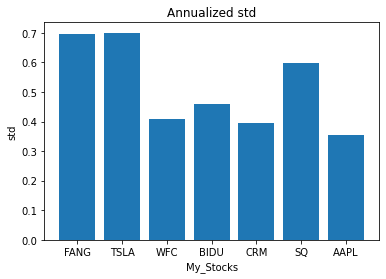

In [10]:
#calculate the annualized std dev 
std = np.sqrt(daily_var * 252)

# grab each standard deviation value for the y axis
height = []
# for key in daily_std.keys():
#     height.append(daily_std[key])
# height

for key in std.keys():
    height.append(std[key])
# arrange keys on x axis based on length
#x_pos = np.arange(len(daily_std.keys()))
x_pos = np.arange(len(std.keys()))

# plot bars
plt.bar(x_pos, height)
 
# create names on the x-axis
#plt.xticks(x_pos, daily_std.keys())
plt.xticks(x_pos, std.keys())
# label chart
plt.xlabel("My_Stocks")
plt.ylabel("std")
plt.title("Annualized std")

# show graphic
plt.show()

In [11]:
#calculate correlation matrix
daily_log_returns.corr()

Symbols,FANG,TSLA,WFC,BIDU,CRM,SQ,AAPL
Symbols,,,,,,,
FANG,1.000000,0.240387,0.517538,0.271022,0.243505,0.261434,0.274201
TSLA,0.240387,1.000000,0.206655,0.358578,0.417851,0.423844,0.430096
WFC,0.517538,0.206655,1.000000,0.279328,0.334845,0.302610,0.392795
BIDU,0.271022,0.358578,0.279328,1.000000,0.389197,0.439312,0.431584
CRM,0.243505,0.417851,0.334845,0.389197,1.000000,0.588629,0.594031
SQ,0.261434,0.423844,0.302610,0.439312,0.588629,1.000000,0.566571
AAPL,0.274201,0.430096,0.392795,0.431584,0.594031,0.566571,1.000000


In [12]:
selected = list(stock_data.columns)

daily_log_returns = daily_log_returns 

expected_returns = daily_log_returns.mean() 

cov_daily = daily_log_returns.cov() 




In [13]:
daily_log_returns = stock_data[selected].pct_change() 
expected_returns = daily_log_returns.mean() 
cov_quarterly = daily_log_returns.cov() 

single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
my_portfolio = return_portfolios(expected_returns, cov_quarterly) 
weights, returns, risks = optimal_portfolio(daily_log_returns[1:])

# df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
# plt.plot(risks, returns, 'y-o')
# plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)
# plt.show()

     pcost       dcost       gap    pres   dres
 0: -1.4693e-03 -1.0040e+00  1e+00  2e-16  3e+00
 1: -1.4727e-03 -1.3993e-02  1e-02  1e-16  4e-02
 2: -1.7257e-03 -4.0849e-03  2e-03  4e-17  7e-03
 3: -3.5517e-03 -5.0129e-03  1e-03  2e-16  2e-03
 4: -3.9040e-03 -3.9494e-03  5e-05  1e-16  6e-05
 5: -3.9383e-03 -3.9387e-03  5e-07  8e-19  6e-07
 6: -3.9386e-03 -3.9386e-03  5e-09  1e-16  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4663e-03 -1.0040e+00  1e+00  2e-16  3e+00
 1: -1.4697e-03 -1.3988e-02  1e-02  1e-16  4e-02
 2: -1.7222e-03 -4.0787e-03  2e-03  7e-17  7e-03
 3: -3.5487e-03 -5.0024e-03  1e-03  8e-16  2e-03
 4: -3.8926e-03 -3.9375e-03  4e-05  1e-16  6e-05
 5: -3.9264e-03 -3.9269e-03  4e-07  1e-18  6e-07
 6: -3.9267e-03 -3.9267e-03  4e-09  3e-16  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4630e-03 -1.0040e+00  1e+00  0e+00  3e+00
 1: -1.4663e-03 -1.3982e-02  1e-02  7e-17  4e-02
 2: -1.7183e-03 -4.0718e

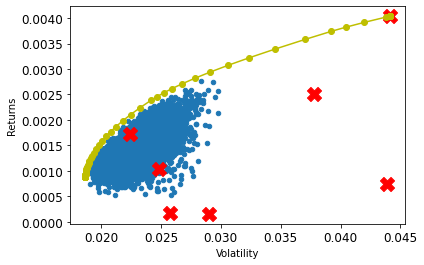

In [14]:
my_portfolio.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)



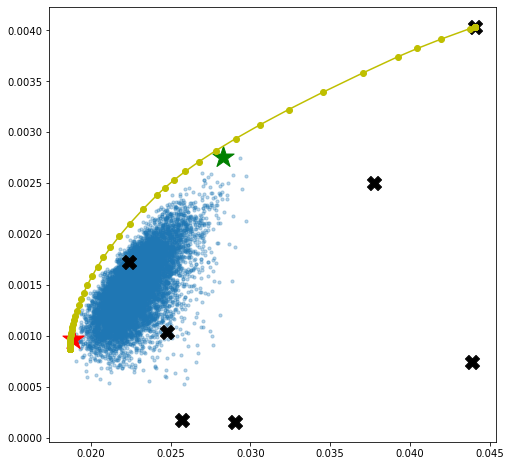

In [15]:
rf = 0
min_vol = my_portfolio.iloc[my_portfolio['Volatility'].idxmin()]
optimal_risk = my_portfolio.iloc[((my_portfolio['Returns']-rf)/my_portfolio['Volatility']).idxmax()]


#Plotting optimal portfolio

plt.subplots(figsize=(8,8))
#df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')

plt.scatter(my_portfolio['Volatility'], my_portfolio['Returns'], marker ='o', s=10, alpha=0.3)
plt.scatter(min_vol[1], min_vol[0], color = 'red', marker = '*', s = 500) 
plt.scatter(optimal_risk[1], optimal_risk[0], color = 'g', marker = '*', s=500)
plt.scatter(single_asset_std,expected_returns,marker='X',color='black',s=200)
# the green star represents the optimal risky portfolio

In [16]:
optimal_risk

Returns        0.002754
Volatility     0.028308
FANG Weight    0.031656
TSLA Weight    0.463694
WFC Weight     0.035044
BIDU Weight    0.010880
CRM Weight     0.060615
SQ Weight      0.131490
AAPL Weight    0.266622
Name: 1131, dtype: float64

In [17]:
min_vol

Returns        0.000967
Volatility     0.018876
FANG Weight    0.032276
TSLA Weight    0.003878
WFC Weight     0.255982
BIDU Weight    0.114410
CRM Weight     0.248235
SQ Weight      0.014495
AAPL Weight    0.330723
Name: 2442, dtype: float64

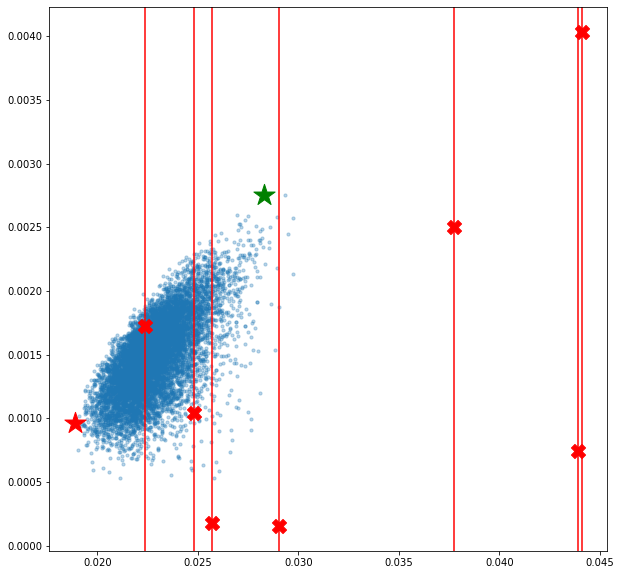

In [18]:
single_asset_std=np.sqrt(np.diagonal(cov_daily))

plt.subplots(figsize=(10,10))
plt.scatter(my_portfolio['Volatility'], my_portfolio['Returns'], marker ='o', s=10, alpha=0.3)
plt.scatter(min_vol[1], min_vol[0], color = 'red', marker = '*', s = 500) 
plt.scatter(optimal_risk[1], optimal_risk[0], color = 'g', marker = '*', s=500)

plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)
for xc in single_asset_std:
    plt.axvline(x=xc, color='red')